# House Price Prediction

```Data/house_price.csv```には、住宅の価格(```SalePrice```)と住宅の関連情報が格納されています。

- このデータを用いて、住宅の価格(```SalePrice```)を予測するモデルを構築、評価しなさい。
- データ中身を確認しながら、適切な特徴量エンジニアリングやモデル選定ための考えもまとめてください。

In [69]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [85]:
housing_df=pd.read_csv('Data/house_price.csv')
pd.set_option('display.max_rows', 500)
housing_df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [89]:
numeric_features = housing_df.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [91]:
corr = numeric_features.corr()
print (corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-5:])
housing_df.OverallQual.unique()


SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2], dtype=int64)

In [93]:
quality_pivot = housing_df.pivot_table(index='OverallQual',
                  values='SalePrice', aggfunc=np.median)
quality_pivot

,SalePrice
OverallQual,
1,50150
2,60000
3,86250
4,108000
5,133000
6,160000
7,200141
8,269750
9,345000


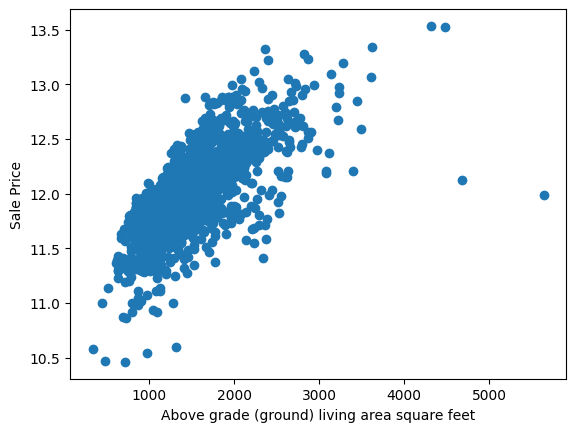

In [94]:
import matplotlib.pyplot as plt
target = np.log(housing_df.SalePrice)
plt.scatter(x=housing_df['GrLivArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Above grade (ground) living area square feet')
plt.show()

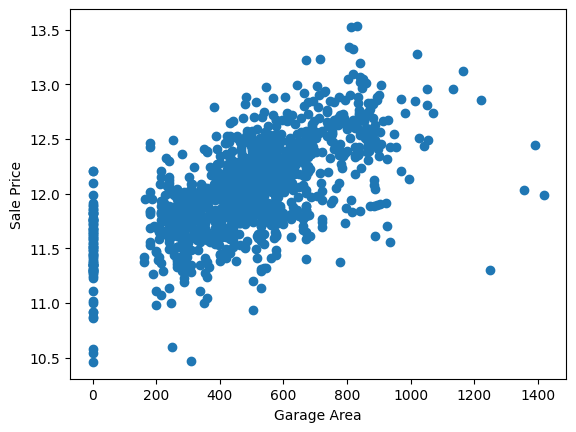

In [95]:
plt.scatter(x=housing_df['GarageArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

In [98]:
nulls = pd.DataFrame(housing_df.isnull().sum().sort_values(ascending=False)[:20])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81


In [99]:
cats = housing_df.select_dtypes(exclude=[np.number])
cats.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,588,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,3,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,445,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [102]:
print ("Original: \n")
print (housing_df.Street.value_counts(), "\n")
housing_df['dummy_street'] = pd.get_dummies(housing_df.Street, drop_first=True)
print (housing_df.dummy_street.value_counts())

Original: 

Street
Pave    1454
Grvl       6
Name: count, dtype: int64 

dummy_street
True     1454
False       6
Name: count, dtype: int64


In [104]:
data = housing_df.select_dtypes(include=[np.number]).interpolate().dropna()
sum(data.isnull().sum() != 0)

0

In [107]:
y = np.log(housing_df.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(
                          X, y, random_state=42, test_size=.33)

In [112]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)
print ("R^2 is: \n", model.score(X_test, y_test))
predictions = model.predict(X_test)
from sklearn.metrics import mean_squared_error
print ('RMSE is: \n', mean_squared_error(y_test, predictions))

R^2 is: 
 0.8627547060335294
RMSE is: 
 0.0233909053041615


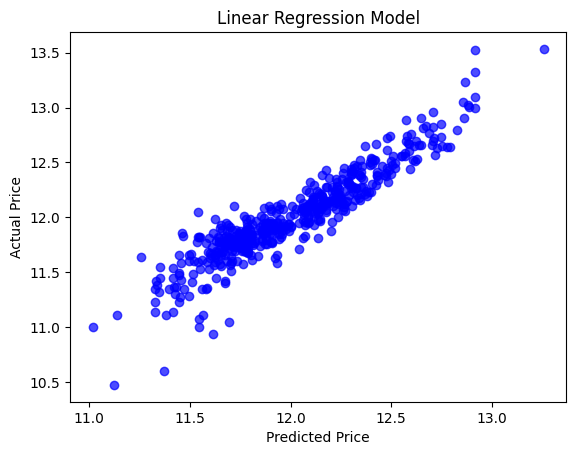

In [113]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()